In [1]:
import re
from konlpy.tag import Kkma
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
import datetime
start_time = datetime.datetime.now()
from konlpy.tag import Kkma
from konlpy.utils import pprint
from collections import Counter
kkma = Kkma()

# 데이터 csv로 변경

In [90]:
def read_kko_msg(filename):
    with open(filename, encoding='utf-8') as f:
        msg_list = f.readlines()
    return msg_list

def apply_kko_regex(msg_list):
    kko_pattern = re.compile("\[([\S\s]+)\] \[(오전|오후) ([0-9:\s]+)\] ([^\n]+)")
    kko_date_pattern = re.compile("--------------- ([0-9]+년 [0-9]+월 [0-9]+일) ")

    emoji_pattern = re.compile("["u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)

    kko_parse_result = list()
    cur_date = ""

    for msg in msg_list:
        # 날짜 부분인 경우
        if len(kko_date_pattern.findall(msg)) > 0:
            cur_date = dt.datetime.strptime(kko_date_pattern.findall(msg)[0], "%Y년 %m월 %d일")
            cur_date = cur_date.strftime("%Y-%m-%d")
        else:
            kko_pattern_result = kko_pattern.findall(msg)
            if len(kko_pattern_result) > 0:
                tokens = list(kko_pattern_result[0])
                # 이모지 데이터 삭제-> 안하고 싶은데여..
                """
                tokens[-1] = re.sub(emoji_pattern, "", tokens[-1])
                """
                tokens.insert(0, cur_date)
                kko_parse_result.append(tokens)
                

    kko_parse_result = pd.DataFrame(kko_parse_result, columns=["Date", "Speaker", "timetype", "time", "contents"])
    kko_parse_result.to_csv("kko_regex.csv", index=False)

    return kko_parse_result

if __name__ == '__main__':
    msg_list = read_kko_msg("이승희대외활동.txt")
    apply_kko_regex(msg_list)
    
    
df = pd.read_csv("kko_regex.csv",encoding='utf-8')
df.head()

,Date,Speaker,timetype,time,contents
0,2020-12-27,(알 수 없음),오후,6:54,저희오늘회의맞지요1
1,2020-12-27,(알 수 없음),오후,6:54,?
2,2020-12-27,이승희,오후,6:56,넵 7시요
3,2020-12-27,차정현(J),오후,6:58,https://sookmyung-ac-kr.zoom.us/j/87504233279?...
4,2020-12-27,차정현(J),오후,6:58,7시까지 오세요들~~~~


# 데이터 날짜 가공

In [91]:
df[df['contents'].isnull()]# 대부분 이모티콘

,Date,Speaker,timetype,time,contents


In [92]:
df.dropna(inplace=True)
df=df.reset_index(drop=True)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3319 entries, 0 to 3318
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      3319 non-null   object
 1   Speaker   3319 non-null   object
 2   timetype  3319 non-null   object
 3   time      3319 non-null   object
 4   contents  3319 non-null   object
dtypes: object(5)
memory usage: 129.8+ KB


In [94]:
#datetime으로 변경
df['Date'] = pd.to_datetime(df['Date'])
# 년,월,일로 변경
df["year"] = df['Date'].dt.strftime('%Y')
df["month"] = df['Date'].dt.strftime('%m')
df["day"] = df['Date'].dt.strftime('%d')

df['24time'] = df['timetype'] + ' ' + df['time']
df['24time'] = df['24time'].map(lambda x : x.replace('오전','AM'))
df['24time'] = df['24time'].map(lambda x : x.replace('오후','PM'))
#24시간으로 datetime형 변경
temp = []
transform_time = []
for i in range(len(df)):
    time = df['24time'][i]
    temp.append(dt.datetime.strptime(time, '%p %I:%M'))
    transform_time.append(temp[i].time())

df['24time'] = transform_time

# 문자의 길이 반환

title_len=[]
    
for i in range(len(df)):
    ttl = len(df['contents'][i])
    title_len.append(ttl)

df['length'] = title_len

# 시간을 추출

hours_list=[]

for i in range(len(df)):
    hours = df['24time'][i].hour
    hours_list.append(hours)
    
df['hour'] = hours_list

# 분을 추출

minutes_list=[]

for i in range(len(df)):
    minutes = df['24time'][i].minute
    minutes_list.append(minutes)
df['minutes'] = minutes_list

#time column drop
df=df.drop(['time'],axis=1)

df.head()



    
    


,Date,Speaker,timetype,contents,year,month,day,24time,length,hour,minutes
0,2020-12-27,(알 수 없음),오후,저희오늘회의맞지요1,2020,12,27,18:54:00,10,18,54
1,2020-12-27,(알 수 없음),오후,?,2020,12,27,18:54:00,1,18,54
2,2020-12-27,이승희,오후,넵 7시요,2020,12,27,18:56:00,5,18,56
3,2020-12-27,차정현(J),오후,https://sookmyung-ac-kr.zoom.us/j/87504233279?...,2020,12,27,18:58:00,82,18,58
4,2020-12-27,차정현(J),오후,7시까지 오세요들~~~~,2020,12,27,18:58:00,13,18,58


In [95]:
df['Speaker'].astype('category')

0       (알 수 없음)
1       (알 수 없음)
2            이승희
3         차정현(J)
4         차정현(J)
          ...   
3314          수빈
3315    (알 수 없음)
3316         이재우
3317         이승희
3318         이승희
Name: Speaker, Length: 3319, dtype: category
Categories (5, object): ['(알 수 없음)', '수빈', '이승희', '이재우', '차정현(J)']

In [96]:
df['Speaker'].value_counts()

이승희         1043
수빈           900
차정현(J)       647
(알 수 없음)     525
이재우          204
Name: Speaker, dtype: int64

## 피쳐 정리

In [97]:
# -*- coding: utf-8 -*-
def preprocessing(df):
    name_list=df['Speaker'].unique()
    #기본 데이터 프레임 생성(이름, 빈도)
    feature=pd.DataFrame(df['Speaker'].value_counts())
    feature.rename(columns = {'Speaker':'frequency'}, inplace=True)

    #전체 글자 수-> 시간이 좀 오래 걸림
    for i in ['length','notice','vote','file','link','image','video','emoticon','group_call','?','!','happiness', 'sadness','sorry'#,'proposal'
             ]:
        feature.at[:,i] = 0
    for i in range(len(df)):
        for name in name_list:
            if (df.at[i,'Speaker']==name):
                feature.at[name,'length']+=len(df.at[i,'contents'])  
                #톡게시판, 파일, 링크 파싱
                if "톡게시판 '공지': " in df.at[i,'contents']:
                    feature.at[name,'notice']+=1
                if "톡게시판 '투표':" in df.at[i,'contents']:
                    feature.at[name,'vote']+=1
                if "파일: " in df.at[i,'contents']:
                    feature.at[name,'file']+=1
                if ("http://" in df.at[i,'contents']) or ("https://" in df.at[i,'contents']):
                    feature.at[name,'link']+=1
                #사진 한 장
                if df.at[i,'contents']=="사진":
                    feature.at[name,'image']+=1
                #사진 여러 장(정규 표현식 사용)
                if df.at[i,'contents'] in re.compile("사진\s\d장").findall(df.at[i,'contents']):
                    feature.at[name,'image']+=1
                if df.at[i,'contents']=="동영상":
                    feature.at[name,'video']+=1
                if df.at[i,'contents']=="이모티콘":
                    feature.at[name,'emoticon']+=1
                if df.at[i,'contents']=="그룹콜 해요":
                    feature.at[name,'group_call']+=1
                #물음표 개수
                count_qmark=df.at[i,'contents'].count('?')
                feature.at[name,'?']+=count_qmark
                #느낌표 개수
                count_emark=df.at[i,'contents'].count('!')
                feature.at[name,'!']+=count_emark
                #기쁨
                count_hmark=df.at[i,'contents'].count('ㅋ')
                feature.at[name,'happiness']+=count_hmark
                #슬픔
                count_smark1=df.at[i,'contents'].count('ㅜ')
                count_smark2=df.at[i,'contents'].count('ㅠ')
                feature.at[name,'sadness']+=(count_smark1+count_smark2)
                #미안, 죄송
                count_somark1=df.at[i,'contents'].count('죄송')
                count_somark2=df.at[i,'contents'].count('미안')
                feature.at[name,'sorry']+=(count_somark1+count_somark2)
                #청유형, 명령형 종결어미 개수
                """ 알 수 없는 UnicodeDecodeError 이거 때문에 망했음... 도대체 왜...
                text_pos=kkma.pos(df.at[i,'contents'])
                count=0
                for i in range(len(text_pos)):
                    count+=text_pos[i][1].count('EFA')+text_pos[i][1].count('EFO')
                feature.at[name,'proposal']+=count
                """
                
            
    #per은 채팅 횟수 대비 채팅의 길이(그다지 의미는 없어보임)
    #feature['per'] = round(feature['length']/feature['frequency'],2)

    return feature

In [98]:
import time
start = time.time()

feature = preprocessing(df)
print("time :", time.time() - start)

time : 0.9265193939208984


In [99]:
feature

,frequency,length,notice,vote,file,link,image,video,emoticon,group_call,?,!,happiness,sadness,sorry
이승희,1043,9125,0,0,0,8,34,0,0,0,184,34,285,2,3
수빈,900,9322,0,0,6,3,43,0,0,0,101,130,1266,197,0
차정현(J),647,8438,0,0,3,11,8,0,3,0,106,95,327,0,1
(알 수 없음),525,9384,0,0,15,3,23,0,2,0,96,84,256,66,0
이재우,204,2026,0,0,13,1,35,0,5,0,18,2,44,0,1


## 텍스트 분석

In [100]:
"""
from konlpy.tag import Kkma
from konlpy.utils import pprint
from collections import Counter
kkma = Kkma()
text="발표 해주세요. 발표는 네가 맡거라. 이리 오너라. 이거 해라. 저거 해줘. 이거 하세요. 이거 합시다. 하십시오. 문 잠그렴!"
text_pos=kkma.pos(text)
count=0
for i in range(len(text_pos)):
    count+=text_pos[i][1].count('EFA')+text_pos[i][1].count('EFO')
print(count)
"""

'\nfrom konlpy.tag import Kkma\nfrom konlpy.utils import pprint\nfrom collections import Counter\nkkma = Kkma()\ntext="발표 해주세요. 발표는 네가 맡거라. 이리 오너라. 이거 해라. 저거 해줘. 이거 하세요. 이거 합시다. 하십시오. 문 잠그렴!"\ntext_pos=kkma.pos(text)\ncount=0\nfor i in range(len(text_pos)):\n    count+=text_pos[i][1].count(\'EFA\')+text_pos[i][1].count(\'EFO\')\nprint(count)\n'

In [101]:
feature.corr()

,frequency,length,notice,vote,file,link,image,video,emoticon,group_call,?,!,happiness,sadness,sorry
frequency,1.000000,0.789634,NaN,NaN,-0.793560,0.492634,0.204285,NaN,-0.943656,NaN,0.910412,0.441078,0.552629,0.340502,0.411259
length,0.789634,1.000000,NaN,NaN,-0.429817,0.471937,-0.174070,NaN,-0.831613,NaN,0.783667,0.734580,0.491245,0.410561,-0.029351
notice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vote,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
file,-0.793560,-0.429817,NaN,NaN,1.000000,-0.782288,0.068385,NaN,0.550149,NaN,-0.753597,-0.154586,-0.255184,0.096195,-0.667020
link,0.492634,0.471937,NaN,NaN,-0.782288,1.000000,-0.670532,NaN,-0.227331,NaN,0.636675,0.198037,-0.106005,-0.404795,0.492187
image,0.204285,-0.174070,NaN,NaN,0.068385,-0.670532,1.000000,NaN,-0.356892,NaN,-0.049621,-0.130409,0.460059,0.536247,0.030154
video,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emoticon,-0.943656,-0.831613,NaN,NaN,0.550149,-0.227331,-0.356892,NaN,1.000000,NaN,-0.821803,-0.526276,-0.653168,-0.549694,-0.192450
group_call,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

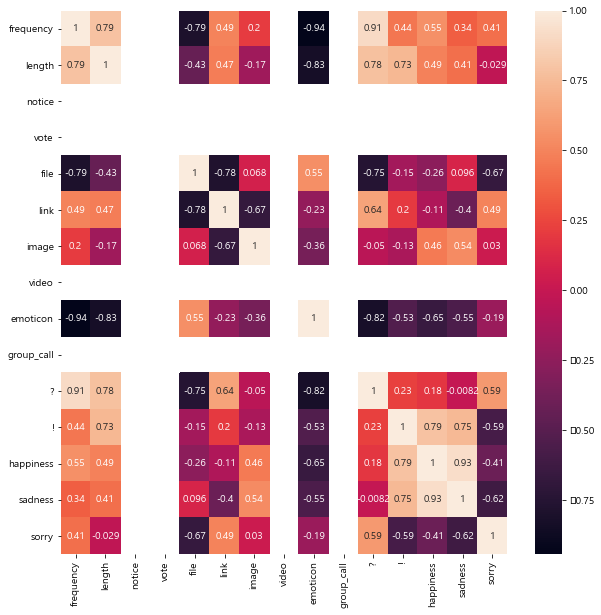

In [102]:
plt.figure(figsize=(10,10))
sns.heatmap(data=feature.corr(), annot=True)

In [ ]:
#df[df['Speaker']=='남기쁨] [오후 11:14] [한견']

In [ ]:
#df[df['Speaker']=='남기쁨] [오후 10:22] [남기쁨']

# 색깔 리스트, 인원 리스트 만들기

In [ ]:
# 색깔 리스트, 인원 리스트 만들기
color_list = ['r','g','b','c','y','m','w']
people_list = list(df['Speaker'].unique())
color_people_list = []
for i in range(len(people_list)):
    color_people_list.append((people_list[i],color_list[i]))
color_people_list

# 시간별 채팅 kdeplot

In [ ]:
def kdeplot():
    fig, ax = plt.subplots(figsize=(10,5))
    g = sns.kdeplot(df['hour'][(df['Speaker'] == people_list[0]) & (df["hour"].notnull())], color=color_people_list[0][1], shade = True)
    for i in color_people_list[1:]:
        g = sns.kdeplot(df['hour'][(df['Speaker'] == i[0]) & (df["hour"].notnull())], color=i[1], shade = True)
    g.set_xlabel("viewCount")
    g.set_ylabel("Frequency")
    plt.title("시간별 채팅 비율")
    g = g.legend(people_list)
    return g


In [ ]:
kdeplot()

# pie chart 그리기

In [ ]:
def piechart_per():
    ratio = []
    per_sum = feature['per'].sum()
    for i in range(len(feature)):
        ratio.append(round(feature.iloc[i]['per']/per_sum*100,1))
    ratio
    plt.figure(figsize=(8,8))
    plt.pie(ratio, labels=list(feature.index), autopct='%.1f%%')
    plt.title('채팅 비율')
    plt.show()
    return 

In [ ]:
piechart_per()

In [ ]:
feature

In [ ]:
def piechart_frequency():
    ratio = []
    fre_sum = feature['frequency'].sum()
    for i in range(len(feature)):
        ratio.append(round(feature.iloc[i]['per']/fre_sum*100,1))
    ratio
    plt.figure(figsize=(8,8))
    plt.pie(ratio, labels=list(feature.index), autopct='%.1f%%')
    plt.title('채팅 비율')
    plt.show()
    return 

In [ ]:
piechart_frequency()

In [ ]:
end_time = datetime.datetime.now()
print("time :", end_time - start_time)